### Model Fitting using Training set sampled images

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import glob
import cv2

import os
import sys  
import re
sys.path.insert(0, '../dip_utils')

from matrix_utils import arr_info
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair, 
                       vis_triple)
%run watershed.ipynb
%run calibrate.ipynb
%run greyscale.ipynb
%run image_stacking.ipynb
%run whitep_elimination.ipynb
%run skew_correction.ipynb

In [2]:
path = '../sampled_images'
dest = '../stacked_new'

In [3]:
files = glob.glob('%s/*' % dest)
for f in files:
    os.remove(f)

In [4]:
image_stacking(path, dest)

In [5]:
clear = '../stacked_new/NTU0.jpg'

In [6]:
img_lib = []

In [7]:
for dic in os.listdir(dest):
    if dic != '.ipynb_checkpoints':
        img_lib.append(dic)

In [8]:
markers_lib = dict()
for img in img_lib:
    markers = watershed(dest, img)
    markers_lib[img] = markers

In [9]:
bottom_lib = dict()
left_lib = dict()
top_lib = dict()
right_lib = dict()

In [10]:
# Acquire the bottom and the leftmost point of the ROI
for key in markers_lib:
    bottom = np.where(markers_lib[key]==1)[0].max()
    bottom_lib[key] = bottom
    left = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].min()
    left_lib[key] = left
    top = np.where(markers_lib[key]==2)[0].min()
    top_lib[key] = top
    right = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].max()
    right_lib[key] = right

In [11]:
# Some threshold values
# 500 50 80 350
vert_thres = 500
horz_thres = 50
length = 80
dist = 330   # distance between the two cuvettes

In [12]:
# Avoid Extracting incorrect ROI
count = []
for key in markers_lib:
    count.append(0)
    while markers_lib[key][bottom_lib[key]-vert_thres, left_lib[key]+horz_thres] == 1:
        left_lib[key] += horz_thres
        count[-1] = 1

In [13]:
count = np.array(count)
recall = 1 - np.mean(np.sum(count) / np.size(count))
recall

0.9736842105263158

In [14]:
# Corners: Top left, Top right, Bottom left, Bottom right
src_corners = dict()
for key in markers_lib:
    corners = []
    tl = [left_lib[key], top_lib[key]]
    tr = [right_lib[key], top_lib[key]]
    bl = [left_lib[key], bottom_lib[key]]
    br = [right_lib[key], bottom_lib[key]]
    corners.append(tl)
    corners.append(tr)
    corners.append(bl)
    corners.append(br)
    src_corners[key] = (corners)

In [15]:
dst_corners = dict()
for key in markers_lib:
    dst_corners[key] = get_destination_points(src_corners[key])

In [16]:
# Calibration
calibrated = {}
for img in img_lib:
    org = plt.imread(os.path.join(dest, img))
    org = lab_trans(clear, org)
    calibrated[img] = org

In [17]:
greyscale = {}
for img in img_lib:
    grey = calibrated[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [18]:
deskewed_lib = dict()
dimensions = dict()
for key in greyscale:
    deskewed = unwarp(dest, key, np.float32(src_corners[key]), dst_corners[key][0])
    dimensions[key] = (dst_corners[key][1], dst_corners[key][2])
    deskewed_lib[key] = deskewed

In [19]:
h, w = deskewed_lib['NTU0.jpg'].shape[:2]
resize_lib = dict()
resize_dim = dict()
ref = (dimensions['NTU0.jpg'][0], dimensions['NTU0.jpg'][1])
for key in deskewed_lib:
    dim = (dimensions[key][0] / ref[0], dimensions[key][1] / ref[1])
    img_dim = (int(h*dim[0]), int(w*dim[1]))
    resize_lib[key] = cv2.resize(deskewed_lib[key], img_dim, interpolation=cv2.INTER_AREA)

In [20]:
greyscale = {}
for img in resize_lib:
    grey = resize_lib[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [21]:
# x_left represents the ROI of the reference, while x_right represents the ROI of the sample
x_left = []
x_right = []
y_left = []
y_right = []

In [22]:
for key in deskewed_lib:
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(dst_corners[key][1], dst_corners[key][1]-vert_thres, -1):
        x.append(i)
        y.append(np.mean(deskewed_lib[key][i-1:i, horz_thres:horz_thres+length]))
    x_left.append(x)
    y_left.append(y)
    for i in range(dst_corners[key][1], dst_corners[key][1]-vert_thres, -1):
        x1.append(i)
        y1.append(np.mean(deskewed_lib[key][i-1:i, horz_thres+dist:
                                         horz_thres+dist+length]))
    x_right.append(x1)
    y_right.append(y1)

In [23]:
x_left = np.array(x_left)
x_right = np.array(x_right)
y_left = np.array(y_left)
y_right = np.array(y_right)

In [24]:
arr_info(x_left), arr_info(y_left)

(((38, 500), dtype('int64'), 54, 766),
 ((38, 500), dtype('float64'), 14.75, 179.3875))

In [25]:
# plot the ratio with respect to NTU
num = []
for img in img_lib:
    img = img.replace('_', '.')
    a = img.split('NTU')
    a = [b.split('.jpg') for b in a]
    for item in a:
        item.remove("")
    num.append(a)

In [26]:
NTU = []
for i in num:
    for j in i:
        if len(j) != 0:
            NTU.append(float(j[0]))

In [27]:
diff = {}
for i in range(x_left.shape[0]):
    diff[img_lib[i]] = np.mean(y_right[i] - y_left[i])
diff

{'NTU85.jpg': 21.71955833333333,
 'NTU190.jpg': 33.458325,
 'NTU156.jpg': 29.552416666666666,
 'NTU41.jpg': 11.306775,
 'NTU87_5.jpg': 21.441324999999996,
 'NTU44_2.jpg': 22.238966666666666,
 'NTU76_1.jpg': 20.653716666666668,
 'NTU0.jpg': -1.3484083333333334,
 'NTU290.jpg': 42.85125,
 'NTU113.jpg': 25.543200000000002,
 'NTU69_9.jpg': 19.06898333333334,
 'NTU182.jpg': 30.08486666666667,
 'NTU142.jpg': 33.14588333333333,
 'NTU36_5.jpg': 13.296375,
 'NTU16_1.jpg': 6.9844333333333335,
 'NTU167.jpg': 31.639708333333328,
 'NTU108.jpg': 25.536841666666668,
 'NTU208.jpg': 32.846091666666666,
 'NTU250.jpg': 37.743941666666665,
 'NTU212.jpg': 33.540283333333335,
 'NTU235.jpg': 37.319799999999994,
 'NTU281.jpg': 40.09426666666666,
 'NTU266.jpg': 37.66705833333334,
 'NTU256.jpg': 36.611375,
 'NTU145.jpg': 25.841924999999996,
 'NTU126.jpg': 29.56655,
 'NTU129.jpg': 26.458225,
 'NTU135.jpg': 31.296766666666663,
 'NTU50.jpg': 21.247841666666666,
 'NTU33_3.jpg': 13.281024999999998,
 'NTU24_5.jpg': 19

In [28]:
diff_c = diff['NTU0.jpg']
for key in diff:
    diff[key] -= diff_c

In [29]:
pixel_intensity = []
for key in diff:
    pixel_intensity.append(diff[key])
pixel_intensity = np.array(pixel_intensity)

In [30]:
sorted(diff.items(), key=lambda x:x[0])

[('NTU0.jpg', 0.0),
 ('NTU108.jpg', 26.88525),
 ('NTU113.jpg', 26.891608333333338),
 ('NTU123.jpg', 24.824616666666664),
 ('NTU126.jpg', 30.91495833333333),
 ('NTU129.jpg', 27.80663333333333),
 ('NTU135.jpg', 32.645174999999995),
 ('NTU142.jpg', 34.49429166666666),
 ('NTU145.jpg', 27.190333333333328),
 ('NTU156.jpg', 30.900824999999998),
 ('NTU167.jpg', 32.98811666666666),
 ('NTU16_1.jpg', 8.332841666666667),
 ('NTU182.jpg', 31.433275000000002),
 ('NTU190.jpg', 34.806733333333334),
 ('NTU208.jpg', 34.1945),
 ('NTU212.jpg', 34.888691666666666),
 ('NTU224.jpg', 37.638475),
 ('NTU235.jpg', 38.668208333333325),
 ('NTU24_5.jpg', 20.774791666666665),
 ('NTU250.jpg', 39.092349999999996),
 ('NTU256.jpg', 37.959783333333334),
 ('NTU266.jpg', 39.01546666666667),
 ('NTU272.jpg', 46.043591666666664),
 ('NTU281.jpg', 41.442674999999994),
 ('NTU290.jpg', 44.19965833333333),
 ('NTU308.jpg', 55.125049999999995),
 ('NTU315.jpg', 53.81128333333333),
 ('NTU330.jpg', 57.63165),
 ('NTU33_3.jpg', 14.6294333

In [31]:
NTU = np.array(NTU)

In [32]:
df = pd.DataFrame({'pixel intensity': pixel_intensity,
                   'turbidity (NTU)': NTU})

In [33]:
#fit simple linear regression model
model = ols('NTU ~ pixel_intensity', data=df).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NTU   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     359.5
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           2.54e-20
Time:                        13:46:56   Log-Likelihood:                -182.75
No. Observations:                  38   AIC:                             369.5
Df Residuals:                      36   BIC:                             372.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -67.2916     12.952     

Text(0.5, 1.0, 'Pixel Intensity V.S. NTU Value')

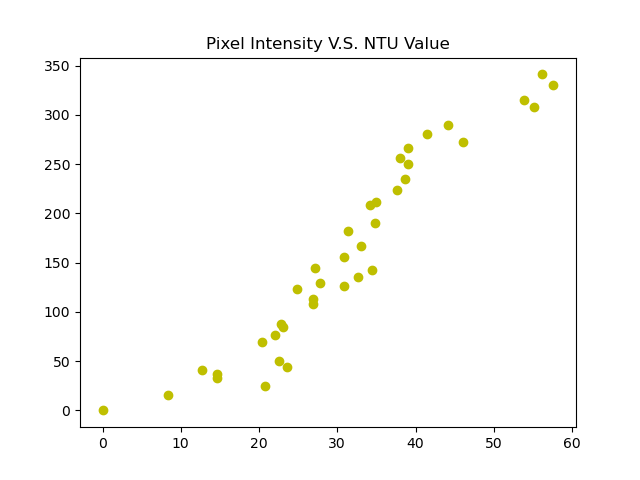

In [34]:
plt.figure()
plt.plot(pixel_intensity, NTU, 'yo')
plt.title('Pixel Intensity V.S. NTU Value')

In [35]:
theta = np.polyfit(pixel_intensity, NTU, 1)

In [39]:
theta

array([  7.29031192, -67.29156936])

In [36]:
plt.plot(pixel_intensity, theta[0]*pixel_intensity + theta[1])

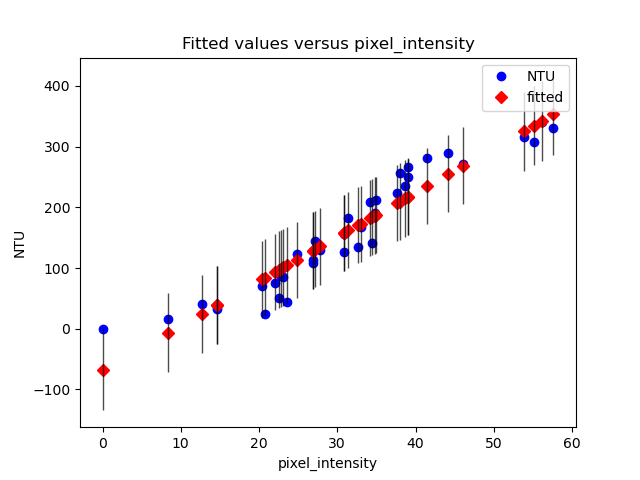

In [37]:
# Figure 8
#define figure size
fig, ax = plt.subplots()

#produce regression plots
#fig = sm.graphics.plot_regress_exog(model, 'pixel_intensity', fig=fig)
fig = sm.graphics.plot_fit(model, 'pixel_intensity', ax=ax)
plt.savefig('../assets/model_fit.pdf', dpi=600)

In [38]:
f = open('../assets/theta.txt', 'w')
f.write(str(diff_c))
f.write('\n')
f.write(str(theta[0]))
f.write('\n')
f.write(str(theta[1]))
f.close()